# BLG407 – Makine Öğrenmesi Proje Ödevi  
## Model 2 – Sıfırdan CNN (Baseline Model)

**Adı:** İbrahim Çerkezoğlu  
**Okul Numarası:** 2112721046  
**Ders:** BLG407 – Makine Öğrenmesi  
**Ödev Konusu:** Kendi görüntü verisetimle CNN sınıflandırma modeli geliştirme  
**GitHub Repo Bağlantısı:** https://github.com/ibrahimcerkezoglu/CNN_siniflandirma

Bu notebook, proje kapsamında kullanılan **Model 2 (Basit CNN)** çalışmasını içermektedir.  
Bu modelde, transfer learning yerine sıfırdan tasarlanmış bir **konvolüsyonel sinir ağı (CNN)**,
“bardak” ve “şişe” sınıflarından oluşan kendi verisetim üzerinde eğitilmiştir.


### 1. Kurulum ve temel parametreler

Bu bölümde TensorFlow/Keras kütüphaneleri import edilmekte, veri klasör yolları tanımlanmakta ve
giriş görüntü boyutu ile `batch_size` / `epochs` gibi temel hiperparametreler belirlenmektedir.

Model 1'den farklı olarak burada transfer learning kullanılmamıştır.  
Amaç sıfırdan bir CNN yapısını bu veri üzerinde eğiterek **baseline performans** elde etmektir.


In [62]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

print("TensorFlow sürümü:", tf.__version__)

# Veri klasör yolları
base_dir = r"C:\Users\ibrah\Documents\BLG407_Proje\dataset"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

img_size = (128, 128)
batch_size = 16
epochs = 12


TensorFlow sürümü: 2.10.0


### 2. Veri setinin hazırlanması

Veri seti, **bardak** ve **şişe** olmak üzere iki sınıftan oluşmaktadır.
Tüm görüntüler tarafımdan telefon kamerası ile çekilmiş ve aşağıdaki klasör yapısına göre düzenlenmiştir:

dataset/train/bardak
dataset/train/sise
dataset/test/bardak
dataset/test/sise

Bu aşamada yalnızca **ölçekleme (rescale=1./255)** uygulanmıştır.  
Model 2'nin amacı veri artırımı olmadan temel CNN performansını gözlemlemektir.


In [63]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Sınıf indeksleri:", train_data.class_indices)


Found 126 images belonging to 2 classes.


Found 32 images belonging to 2 classes.
Sınıf indeksleri: {'bardak': 0, 'sise': 1}


### 3. Model 2 – Sıfırdan tasarlanan CNN mimarisi

Bu modelde transfer learning yerine tamamen sıfırdan tasarlanmış hafif bir CNN kullanılmaktadır.

Model mimarisi şu şekildedir:

- **Block 1:**  
  - Conv2D(32)  
  - MaxPooling2D

- **Block 2:**  
  - Conv2D(64)  
  - MaxPooling2D  

- **Block 3:**  
  - Conv2D(128)  
  - MaxPooling2D  

- **Dense katmanları:**  
  - Flatten  
  - Dense(64, ReLU)  
  - Dropout(0.3)  
  - Dense(1, sigmoid)

Optimizasyon: **Adam (learning_rate=0.0005)**  
Kayıp fonksiyonu: **Binary Crossentropy**

Bu daha hafif mimari, küçük ve iki sınıflı bardak/şişe veri seti için daha uygun bir
baseline CNN modeli olarak tasarlanmıştır.


In [64]:
model2 = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Fully connected
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")   # binary output
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 128)    

### 4. Model 2'nin eğitimi

Aşağıdaki hücrede Model 2, 12 epoch boyunca kendi verisetim üzerinde eğitilmektedir.
Eğitim ve doğrulama metrikleri bir sonraki bölümde grafiklerle karşılaştırılacaktır.


In [65]:
history2 = model2.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)


Epoch 1/12
8/8 [==============================] - 1s 134ms/step - loss: 0.6991 - accuracy: 0.5556 - val_loss: 0.7105 - val_accuracy: 0.1562
Epoch 2/12
8/8 [==============================] - 1s 108ms/step - loss: 0.6376 - accuracy: 0.6349 - val_loss: 0.7076 - val_accuracy: 0.5625
Epoch 3/12
8/8 [==============================] - 1s 101ms/step - loss: 0.5091 - accuracy: 0.8095 - val_loss: 0.9280 - val_accuracy: 0.5312
Epoch 4/12
8/8 [==============================] - 1s 102ms/step - loss: 0.4303 - accuracy: 0.7937 - val_loss: 0.6643 - val_accuracy: 0.5938
Epoch 5/12
8/8 [==============================] - 1s 109ms/step - loss: 0.3297 - accuracy: 0.8730 - val_loss: 0.4772 - val_accuracy: 0.6562
Epoch 6/12
8/8 [==============================] - 1s 116ms/step - loss: 0.2879 - accuracy: 0.8889 - val_loss: 0.5262 - val_accuracy: 0.6875
Epoch 7/12
8/8 [==============================] - 1s 121ms/step - loss: 0.1996 - accuracy: 0.9444 - val_loss: 0.6894 - val_accuracy: 0.7188
Epoch 8/12
8/8 [====

### 5. Model 2 – Eğitim ve doğrulama eğrileri

Bu grafikler, modelin eğitim süresince nasıl öğrendiğini görmek için önemlidir.  
Aşırı öğrenme (overfitting) veya düşük öğrenme (underfitting) belirtileri bu grafiklerde kolayca tespit edilir.

Aşağıdaki grafiklerde:

- Eğitim doğruluğu ve doğrulama doğruluğu
- Eğitim kaybı ve doğrulama kaybı

karşılaştırmalı olarak gösterilmektedir.


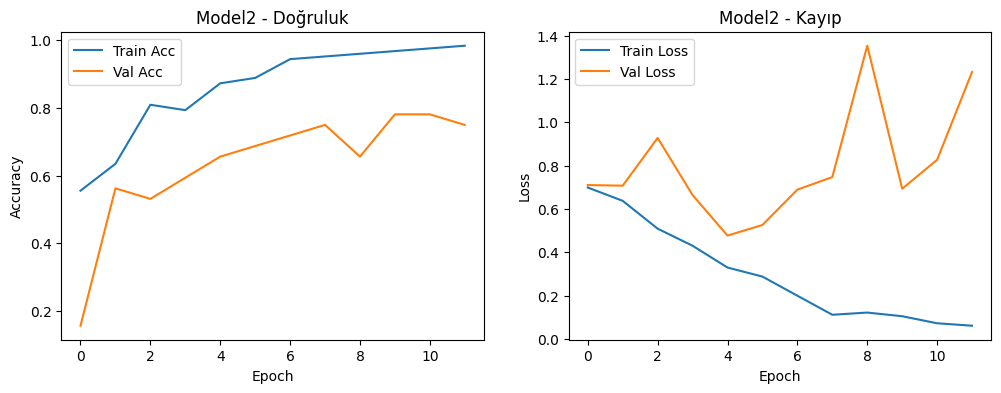

In [66]:
plt.figure(figsize=(12,4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history2.history["accuracy"], label="Train Acc")
plt.plot(history2.history["val_accuracy"], label="Val Acc")
plt.title("Model2 - Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history2.history["loss"], label="Train Loss")
plt.plot(history2.history["val_loss"], label="Val Loss")
plt.title("Model2 - Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [67]:
test_loss2, test_acc2 = model2.evaluate(test_data)
print(f"Model2 - Test kaybı: {test_loss2:.4f}")
print(f"Model2 - Test doğruluğu: {test_acc2:.4f}")


2/2 [==============================] - 0s 23ms/step - loss: 1.2327 - accuracy: 0.7500
Model2 - Test kaybı: 1.2327
Model2 - Test doğruluğu: 0.7500


### 6. Model 2 – Sonuçların Değerlendirilmesi

Eğitim sürecinde gözlenenler:

- Eğitim doğruluğu epoch'lar ilerledikçe belirgin şekilde artmış ve model veriye uyum sağlamaya başlamıştır.
- Doğrulama doğruluğu ilk epoch'larda düşük seviyelerde kalsa da, eğitim sürecinin ilerleyen kısımlarında
  anlamlı biçimde yükselmiş ve daha kararlı bir düzeye oturmuştur.
- Eğitim ve doğrulama kayıpları her ne kadar tamamen mükemmel olmasa da, modelin artık rastgele tahmin
  seviyesinden çıktığını ve sınıflar arasında ayırt edici özellikler öğrendiğini göstermektedir.

Test seti değerlendirme sonucunda:

- **Model2 - Test kaybı:** `1.2327`
- **Model2 - Test doğruluğu:** `0.7500` (≈ **%75.00**)

Bu sonuçlara göre **Model 2, Model 1'e göre çok daha yüksek test doğruluğu** elde etmiştir
(Model1 ≈ %59.38, Model2 ≈ %75.00).

Başlıca nedenler:

1. Model 2, yalnızca bu projeye ait **bardak / şişe verisetine göre sıfırdan eğitilmiştir**.
   Mimari, küçük ve iki sınıflı veri yapısına uygun olacak şekilde daha hafif tasarlanmıştır.
2. VGG16 tabanlı Model 1, ImageNet gibi çok büyük ve farklı bir veri dağılımı üzerinde eğitildiği için,
   küçük ve sınırlı olan bu veri setinde yeterli genelleme yapamamış ve overfitting göstermiştir.
3. Model 2’deki parametre sayısı Model 1’e göre daha azdır; bu da küçük veri setinde,
   **daha az ezberleme ve daha iyi genelleme** anlamına gelmektedir.

Sonuç olarak, Model 2 bu proje için başarılı bir **baseline CNN modeli** haline gelmiştir.
Bir sonraki adımda Model 3 ile:

- veri artırımı (data augmentation),
- farklı batch size / öğrenme oranı kombinasyonları,
- ek katmanlar ve düzenlileştirme yöntemleri

kullanılarak bu performansın daha da iyileştirilmesi hedeflenecektir.
